In [53]:
import numpy as np
import matplotlib.pyplot as plt
import sobol_seq

Problem 1

In [54]:
m_cluster = 50
gamma = -0.2
epsilon = 10**(-3)
delta = 0.01
k_cluster = 10
m = 250
r = 0.95
theta = np.pi/4
k_max = 250
dim = 2

def objective_function(x):
    f1 = np.exp(x[0]-x[1])-np.sin(x[0]+x[1])
    f2 = (x[0]*x[1])**2-np.cos(x[0]+x[1])
    return np.array([f1,f2])

boundaries = np.array([(-10,10) for _ in range (dim)])

Objective Function

In [55]:
def root_objective_function(x:np.ndarray):
    res = 0
    F_array = objective_function(x)
    for f in F_array:
        res += np.abs(f)
    return -1/(1+res)

In [56]:
"""GENERATE POINTS USING SOBOL SEQUENCE"""
def generate_points(dim: int,
                    npoint:int,
                    low=-10,
                    high=10,
                    sobol = True):
    if type(low) != type(high):
        raise TypeError('The type of "low" and "high" should be the same.')
    if type(low) == int:
        boundaries = [(low,high) for _ in range (dim)]
    elif type(low) == list or type(low) == np.ndarray:
        if len(low) != len(high):
            raise TypeError('The length of "low" and "high" should be the same.')
        else:
            boundaries = [(low[i],high[i]) for i in range (len(low))]

    if sobol == True:
        # Generate Sobol sequence points
        sobol_points = sobol_seq.i4_sobol_generate(dim, npoint)
        # Scale the Sobol points to fit within the specified boundaries
        scaled_points = []
        for i in range(dim):
            a, b = boundaries[i]
            scaled_dim = a + sobol_points[:, i] * (b - a)
            scaled_points.append(scaled_dim)
        # Transpose the scaled points to get points per dimension
        scaled_points = np.array(list(map(list, zip(*scaled_points))))
    
    else:
        scaled_points = np.zeros((npoint, dim))
        for i in range(dim):
            min_val, max_val = boundaries[i]
            scaled_points[:, i] = np.random.uniform(min_val, max_val, npoint)

    return scaled_points


In [57]:
k=0
iter_points = {}
iter_points[k] = generate_points(dim,m_cluster,boundaries[:,0],boundaries[:,1])
fitness = np.asarray([root_objective_function(ind) for ind in iter_points[0]])
best_idx = np.argmin(fitness)
x_prime = iter_points[0][best_idx]

radius = (boundaries[:,1]-boundaries[:,0])/2
id_rad = np.argmin(radius)
radii = radius[id_rad]

cluster_center,cluster_radius = np.array([x_prime]),np.array([radii])
# cluster_center[0],cluster_radius[0] = x_prime,radius
print(cluster_center,cluster_radius)

[[-1.25  1.25]] [10.]


In [58]:
"""FUNCTION CLUSTER"""
def function_cluster(y):
    # min_dist_cluster = 10**100
    # for ci,cc in cluster_center.items():
    #     dist = np.linalg.norm(cc-y)
    #     if dist<=min_dist_cluster:
    #         xc = cc
    #         cluster_id = ci
    #         min_dist_cluster = dist
    global cluster_center
    global cluster_radius
    dist_list = np.linalg.norm(cluster_center-y,axis=1)
    min_dist_id = np.argmin(dist_list)
    min_dist = dist_list[min_dist_id]
    xc = cluster_center[min_dist_id]
    xt = (xc + y)/2
    # print(xt,xc,y)
    Fxt = root_objective_function(xt)
    Fxc = root_objective_function(xc)
    Fy = root_objective_function(y)
    # print(Fxt,Fxc,Fy)
    if (Fxt > Fy) & (Fxt > Fxc):
        cluster_center = np.append(cluster_center,[y],axis=0)
        cluster_radius = np.append(cluster_radius, [np.linalg.norm(y-xt)],axis=0)
    elif (Fxt < Fy) & (Fxt < Fxc):
        cluster_center = np.append(cluster_center,[y],axis=0)
        cluster_radius = np.append(cluster_radius, [np.linalg.norm(y-xt)],axis=0)
        function_cluster(xt)
    elif Fy < Fxc:
        cluster_center[min_dist_id] = y
    
    cluster_radius[min_dist_id] =  np.linalg.norm(y-xt)
    # # update radii if the existing corresponding cluster radii is larger than tha candidate
    # if cluster_radius[min_dist_id] > np.linalg.norm(y-xt):
    #     cluster_radius[min_dist_id] =  np.linalg.norm(y-xt)
    
    # return cluster_center,cluster_radius


In [59]:
import importlib.util
import re

spec = importlib.util.spec_from_file_location("spo", r"D:\OneDrive - Institut Teknologi Bandung\[AKADEMIK]\Semester 7-8\TA\Thesis\Spiral Optimization\new\Spiropt.py")
spo = importlib.util.module_from_spec(spec)
spec.loader.exec_module(spo)

In [60]:
seed = np.random.randint(0,100)
print(f"seed={seed}")

while k<k_cluster:
    potential_cluster_center = []
    F = root_objective_function(iter_points[k].T)
    for i in range (m_cluster):
        # If F(x_i)<gamma and x_i is not the center of existing cluster, x_i may have a possibility to become a cluster center
        if len(iter_points[k].T) == 1:
            fungam = F[0][i]
        else:
            fungam = F[i]
        exist_in_cluster_center = any(np.linalg.norm(iter_points[k][i] - ctr) < epsilon for ctr in cluster_center)
        if (fungam < gamma) & (exist_in_cluster_center==False):
            potential_cluster_center.append(iter_points[k][i])
        # print(f'potential_cluster_center:{potential_cluster_center}')
    # Apply function cluster
    for i in range (len(potential_cluster_center)):
        function_cluster(potential_cluster_center[i])
    fitness_k = np.asarray([root_objective_function(ind) for ind in iter_points[k]])
    i_g = np.argmin(fitness)
    x_i_g = iter_points[k][i_g]
    Rn = spo.generate_Rn(dim,theta)
    Sn = r*Rn
    iter_points[k+1] = spo.update_point(set_of_points=iter_points[k],
                                    objective_function=root_objective_function,
                                    Sn=Sn)

    k+=1
print(f"len(cluster_center)={len(cluster_center)}\ncluster_center={cluster_center}")

seed=32
len(cluster_center)=44
cluster_center=[[-0.93828125  0.93828125]
 [ 0.61698018  0.66683215]
 [ 0.66450496  0.69176668]
 [-4.0625      0.3125    ]
 [-0.3125      6.5625    ]
 [ 0.16601563  5.29101562]
 [-0.0390625   5.8359375 ]
 [ 0.09765625  5.47265625]
 [ 0.0859375   2.8828125 ]
 [-2.48945313  0.51523437]
 [ 0.6759237   0.69605883]
 [-2.06640625  0.0921875 ]
 [ 0.55201356  0.62842647]
 [ 0.30530029  0.34125635]
 [ 0.37131984  0.79702986]
 [-0.5822168   1.45651367]
 [-0.84926514  1.06783936]
 [ 0.46438354  0.94577271]
 [ 0.56816548  0.78456171]
 [ 0.45811964  0.91425434]
 [ 0.67043704  0.6873733 ]
 [ 0.34865048  0.57789268]
 [ 0.64749834  0.71201267]
 [ 0.47940946  0.90713287]
 [ 0.47231285  0.90950669]
 [ 0.35620693  0.57033623]
 [ 0.53945095  0.64098908]
 [ 0.65697346  0.69314341]
 [ 0.66082019  0.68468059]
 [ 0.63061958  0.65319275]
 [ 0.62720973  0.6634223 ]
 [ 0.65592067  0.70197066]
 [ 0.66774432  0.68852733]
 [ 0.66652956  0.68974208]
 [ 0.66693448  0.68933716]
 [ 0.6723

Cluster Visualization

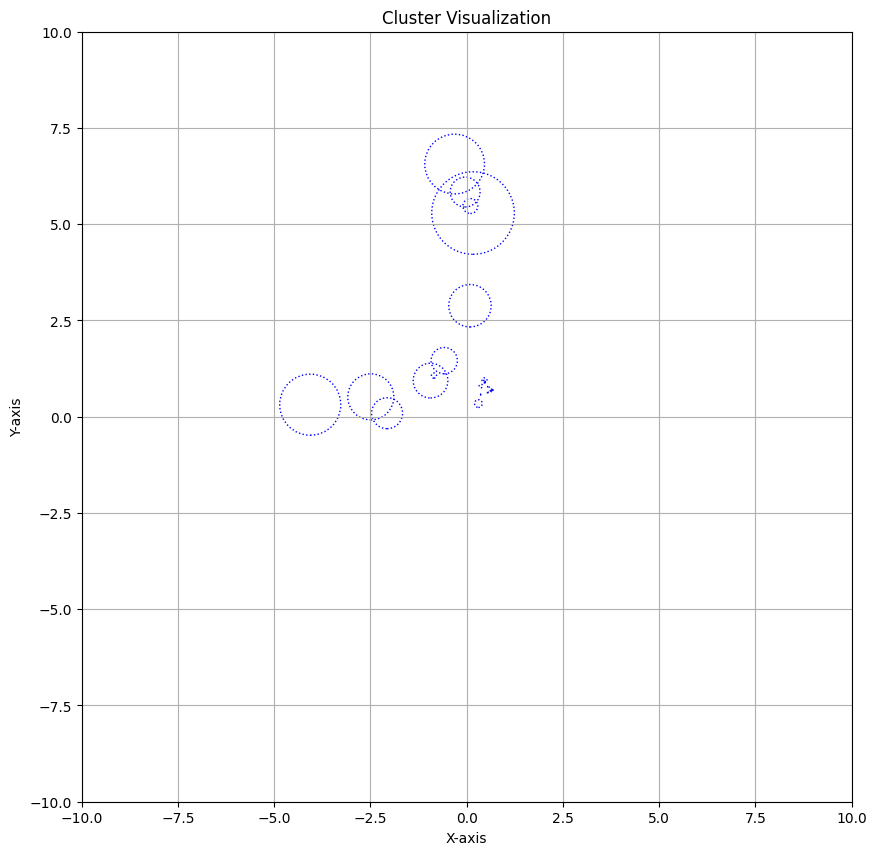

In [61]:
if dim != 2:
    print(f"Dimension {dim} can be visualized using cluster_visualization2D.")
"""Visualization"""
fig, ax = plt.subplots(figsize=(10,10))
for center,radius in zip(cluster_center,cluster_radius):
    circle = plt.Circle(center, radius, fill=False, linestyle='dotted', edgecolor='b')
    ax.add_artist(circle)

# Set axis limits
ax.set_xlim(boundaries[0])
ax.set_ylim(boundaries[1])
# ax.autoscale_view()

# # Add labels (optional)
# for i, center in cluster_center.items():
#     ax.text(center[0], center[1], f'Cluster {i+1}', ha='center', va='bottom')

# Add a title and labels (optional)
ax.set_title('Cluster Visualization')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Show the plot
plt.gca().set_aspect('equal', adjustable='box')  # Make the aspect ratio equal
plt.grid(True)
plt.show()

In [62]:
answ = np.array([[-6.437160, 0.155348],
                 [-0.932122, 1.067870],
                 [-0.155283, 6.439840],
                 [0.163333, 6.122430],
                 [0.667121, 0.690103],
                 [-6.117110, -0.163476]])

possible_cluster_id = []
for i in range (len(cluster_center)):
    for j in range (len(answ)):
        ddist = np.linalg.norm(cluster_center[i]-answ[j])
        if ddist <= cluster_radius[i]:
            possible_cluster_id.append([i,j])
            print(f'cluster_center[{i}] x answ[{j}]')


cluster_center[0] x answ[1]
cluster_center[4] x answ[2]
cluster_center[4] x answ[3]
cluster_center[5] x answ[3]
cluster_center[6] x answ[3]
cluster_center[33] x answ[4]


# Spiral Optimization Evaluation

In [63]:
archive = []
for i in range (len(cluster_center)):
    subbound = np.array([cluster_center[i]-cluster_radius[i],cluster_center[i]+cluster_radius[i]])
    root, root_score = spo.spiral_opt(objective_function=root_objective_function,
                                      boundaries=subbound,
                                      theta=theta,
                                      radius=r,
                                      max_iter=k_max,
                                      max_error=-1+epsilon)
    archive.append(root)
    print(f'\n====== Cluster {i} ======\n')
    print(f'Roots = {archive}')
archive


====== Cluster 0 ======

Roots = [array([-0.92006,  0.92006])]

====== Cluster 1 ======

Roots = [array([-0.92006,  0.92006]), array([0.6532675 , 0.66793382])]

====== Cluster 2 ======

Roots = [array([-0.92006,  0.92006]), array([0.6532675 , 0.66793382]), array([0.67041487, 0.68677001])]



====== Cluster 3 ======

Roots = [array([-0.92006,  0.92006]), array([0.6532675 , 0.66793382]), array([0.67041487, 0.68677001]), array([-1.55948864,  0.40842275])]

====== Cluster 4 ======

Roots = [array([-0.92006,  0.92006]), array([0.6532675 , 0.66793382]), array([0.67041487, 0.68677001]), array([-1.55948864,  0.40842275]), array([0.09309666, 3.14801662])]

====== Cluster 5 ======

Roots = [array([-0.92006,  0.92006]), array([0.6532675 , 0.66793382]), array([0.67041487, 0.68677001]), array([-1.55948864,  0.40842275]), array([0.09309666, 3.14801662]), array([0.00475634, 3.09115428])]

====== Cluster 6 ======

Roots = [array([-0.92006,  0.92006]), array([0.6532675 , 0.66793382]), array([0.67041487, 0.68677001]), array([-1.55948864,  0.40842275]), array([0.09309666, 3.14801662]), array([0.00475634, 3.09115428]), array([0.30715624, 4.02096876])]

====== Cluster 7 ======

Roots = [array([-0.92006,  0.92006]), array([0.6532675 , 0.66793382]), array([0.67041487, 0.68677001]), array([-1.55

[array([-0.92006,  0.92006]),
 array([0.6532675 , 0.66793382]),
 array([0.67041487, 0.68677001]),
 array([-1.55948864,  0.40842275]),
 array([0.09309666, 3.14801662]),
 array([0.00475634, 3.09115428]),
 array([0.30715624, 4.02096876]),
 array([0.91139062, 1.97142188]),
 array([0.05879963, 1.51151287]),
 array([-0.45863019,  0.73792707]),
 array([0.67713186, 0.68981688]),
 array([-1.57795189,  0.00727955]),
 array([0.61506782, 0.6226819 ]),
 array([0.23614876, 0.43737492]),
 array([0.64298761, 0.7091491 ]),
 array([-0.66892016,  1.03353442]),
 array([0.57935871, 0.74452417]),
 array([0.66631034, 0.69075203]),
 array([0.66637192, 0.69064623]),
 array([0.6671212, 0.6901032]),
 array([0.6735315 , 0.68363167]),
 array([0.53855097, 0.55992385]),
 array([0.66712109, 0.69010328]),
 array([0.66712104, 0.6901033 ]),
 array([0.66712136, 0.69010303]),
 array([0.53288363, 0.55425651]),
 array([0.61053061, 0.64606302]),
 array([0.67113682, 0.68604083]),
 array([0.67441385, 0.68274457]),
 array([0.64

In [64]:
if dim == 1:
    list_criteria = [element for sublist in archive for element in sublist] #convert from 2D array into 1D array
else:
    list_criteria = archive
eligible_roots = np.array([x for x in list_criteria if (root_objective_function(x))<-1+epsilon])
eligible_roots

array([[0.6671212 , 0.6901032 ],
       [0.66712109, 0.69010328],
       [0.66712104, 0.6901033 ],
       [0.66712136, 0.69010303],
       [0.66727031, 0.69003495]])

In [65]:
id_duplicated_roots = []
for i in range(len(eligible_roots)):
    for j in range (i+1,len(eligible_roots)):
        if np.linalg.norm(eligible_roots[i]-eligible_roots[j])<delta:
            id_duplicated_roots.append([i,j])
id_duplicated_roots = np.unique(id_duplicated_roots,axis=0)
deselected_id_duplicated_roots = []
for i in range (len(id_duplicated_roots)):
    root_a = root_objective_function(eligible_roots[id_duplicated_roots[i][0]])
    root_b = root_objective_function(eligible_roots[id_duplicated_roots[i][1]])
    if root_a<=root_b:
        id_duplicated_root = id_duplicated_roots[i][1]
    else:
        id_duplicated_root = id_duplicated_roots[i][0]
    deselected_id_duplicated_roots.append(id_duplicated_root)

if deselected_id_duplicated_roots:
    unique_roots = np.ones(len(eligible_roots),dtype=bool)
    unique_roots[deselected_id_duplicated_roots] = False
    final_root = eligible_roots[unique_roots]
else:
    final_root = eligible_roots

final_root

array([[0.6671212, 0.6901032]])